In [1]:
import pickle
import torch
import copy
import random
import numpy as np
import pandas as pd
import torch.nn as nn
import torchvision.models as models
import torchsummary

from skimage import io
from tqdm import tqdm, tqdm_notebook
from PIL import Image
from pathlib import Path
from torchvision import transforms
from sklearn.metrics import f1_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, StratifiedKFold
from torch.utils.data import Dataset, DataLoader
from matplotlib import colors, pyplot as plt
%matplotlib inline

train_on_gpu = torch.cuda.is_available()
if not train_on_gpu:
    print('CUDA is not available.  Training on CPU ...')
else:
    print('CUDA is available!  Training on GPU ...')
torch.cuda.is_available()

CUDA is available!  Training on GPU ...


True

In [2]:
DATA_MODES = ['train', 'val', 'test']
RESCALE_SIZE = 224
DEVICE = torch.device("cuda")
EPOCHS=30
BATCH_SIZE=128
N_FOLDS = 5

SEED = 69
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [3]:
class SimpsonsDataset(Dataset):
    """
    Датасет с картинками, который паралельно подгружает их из папок
    производит скалирование и превращение в торчевые тензоры
    """
    def __init__(self, files, mode):
        super().__init__()
        # список файлов для загрузки
        self.files = sorted(files)
        # режим работы
        self.mode = mode

        if self.mode not in DATA_MODES:
            print(f"{self.mode} is not correct; correct modes: {DATA_MODES}")
            raise NameError

        self.len_ = len(self.files)
     
        self.label_encoder = LabelEncoder()

        if self.mode != 'test':
            self.labels = [path.parent.name for path in self.files]
            self.label_encoder.fit(self.labels)

            with open('label_encoder.pkl', 'wb') as le_dump_file:
                  pickle.dump(self.label_encoder, le_dump_file)
                      
    def __len__(self):
        return self.len_
      
    def load_sample(self, file):
        image = Image.open(file)
        image.load()
        return image
  
    def __getitem__(self, index):
        # для преобразования изображений в тензоры PyTorch и нормализации входа
        transform_list = []
        transform_list.append(transforms.Resize((RESCALE_SIZE, RESCALE_SIZE)))
        if self.mode != 'test':            
            transform_list.append(transforms.RandomHorizontalFlip())
            transform_list.append(transforms.RandomRotation(15))
        transform_list.append(transforms.ToTensor())
        transform_list.append(transforms.Normalize([0.5, 0.5, 0.5], [0.5, 0.5, 0.5]))
        
        transform = transforms.Compose(transform_list)
        x = self.load_sample(self.files[index])
        x = transform(x)
        if self.mode == 'test':
            return x
        else:
            label = self.labels[index]
            label_id = self.label_encoder.transform([label])
            y = label_id.item()
            return x, y

In [4]:
TRAIN_DIR = Path('train/simpsons_dataset')
TEST_DIR = Path('testset/testset')

train_val_files = sorted(list(TRAIN_DIR.rglob('*.jpg')))
test_files = sorted(list(TEST_DIR.rglob('*.jpg')))
train_val_labels = [path.parent.name for path in train_val_files]

In [5]:
def create_dct_path_labels(train_val_files, train_val_labels):
    dct_simpsons = {}
    for label_i in np.unique(train_val_labels).tolist():
        dct_simpsons[label_i] = []

    for path_i, label_i in zip(train_val_files, train_val_labels):
        dct_simpsons[label_i].append(path_i)

    return dct_simpsons

In [6]:
dct_path_train = create_dct_path_labels(train_val_files, train_val_labels)
print(len(train_val_files))

for person in dct_path_train:
    if len(dct_path_train[person]) < 100:
        dct_path_train[person] = dct_path_train[person] * (100 // len(dct_path_train[person]))
        dct_path_train[person].extend(dct_path_train[person][:100 - len(dct_path_train[person])])
        
train_val_files = []
for person in dct_path_train:
    train_val_files.extend(dct_path_train[person])
print(len(train_val_files))

train_val_labels = [path.parent.name for path in train_val_files]
train_val_dataset = SimpsonsDataset(train_val_files, mode='val')

20933
21887


In [7]:
class SimpsonCNN(nn.Module):
  
    def __init__(self, n_classes):
        super().__init__()
        # 224
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=3, out_channels=32, kernel_size=5),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        # 110
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.drop1 = nn.Dropout2d(p=0.25)
        # 54
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        # 26
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.drop2 = nn.Dropout2d(p=0.25)
        # 12
        self.conv5 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        # 5        
        self.fc1 = nn.Sequential(
            nn.Linear(5 * 5 * 256, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
        )
        self.drop3 = nn.Dropout2d(p=0.25)
        self.fc2 = nn.Sequential(
            nn.Linear(1024, 1024),
            nn.BatchNorm1d(1024),
            nn.ReLU(),
        )
        self.out = nn.Linear(1024, n_classes)
        
        for m in self.modules():
            if isinstance(m, nn.Linear):
                m.weight.data = nn.init.xavier_uniform_(m.weight.data,gain=nn.init.calculate_gain('relu'))

    def forward(self, x):
        x = self.conv1(x)
        x = self.drop1(self.conv2(x))
        x = self.conv3(x)
        x = self.drop2(self.conv4(x))
        x = self.conv5(x)
        x = x.view(-1, 5 * 5 * 256)
        x = self.drop3(self.fc1(x))        
        x = self.fc2(x)        
        logits = self.out(x)
        return logits

In [8]:
def fit_epoch(model, train_loader, criterion, optimizer):
    running_loss = 0.0
    running_corrects = 0
    processed_data = 0
  
    for inputs, labels in train_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)
        optimizer.zero_grad()

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        preds = torch.argmax(outputs, 1)
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_data += inputs.size(0)
              
    train_loss = running_loss / processed_data
    train_acc = running_corrects.cpu().numpy() / processed_data
    return train_loss, train_acc

def eval_epoch(model, val_loader, criterion):
    model.eval()
    running_loss = 0.0
    running_corrects = 0
    processed_size = 0

    for inputs, labels in val_loader:
        inputs = inputs.to(DEVICE)
        labels = labels.to(DEVICE)

        with torch.set_grad_enabled(False):
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            preds = torch.argmax(outputs, 1)

        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)
        processed_size += inputs.size(0)
    val_loss = running_loss / processed_size
    val_acc = running_corrects.double() / processed_size
    return val_loss, val_acc

def train(train_files, val_files, model, epochs, batch_size):
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

    history = []
    log_template = "\nEpoch {ep:03d} train_loss: {t_loss:0.4f} \
    val_loss {v_loss:0.4f} train_acc {t_acc:0.4f} val_acc {v_acc:0.4f}"

    with tqdm(desc="epoch", total=epochs) as pbar_outer:
        opt = torch.optim.AdamW(model.parameters())
        #opt = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
        criterion = nn.CrossEntropyLoss()
        scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
            opt, mode='max', factor=0.1, patience=3, verbose=False)
        #scheduler = torch.optim.lr_scheduler.StepLR(opt, step_size=7, gamma=0.1)
        
        for epoch in range(epochs):
            train_loss, train_acc = fit_epoch(model, train_loader, criterion, opt)
            print("loss", train_loss)            
            val_loss, val_acc = eval_epoch(model, val_loader, criterion)
            history.append((train_loss, train_acc, val_loss, val_acc))            
            pbar_outer.update(1)
            tqdm.write(log_template.format(ep=epoch+1, t_loss=train_loss,\
                                           v_loss=val_loss, t_acc=train_acc, v_acc=val_acc))
            scheduler.step(val_acc)
            #scheduler.step()
                
    return history

def predict(model, test_loader):
    with torch.no_grad():
        logits = []
    
        for inputs in test_loader:
            inputs = inputs.to(DEVICE)
            model.eval()
            outputs = model(inputs).cpu()
            logits.append(outputs)
            
    probs = nn.functional.softmax(torch.cat(logits), dim=-1).numpy()
    return probs

In [9]:
n_classes = len(np.unique(train_val_labels))
clf = SimpsonCNN(n_classes).to(DEVICE)
torchsummary.summary(clf.cuda(), (3, RESCALE_SIZE, RESCALE_SIZE))

42
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 220, 220]           2,432
              ReLU-2         [-1, 32, 220, 220]               0
         MaxPool2d-3         [-1, 32, 110, 110]               0
            Conv2d-4         [-1, 32, 108, 108]           9,248
              ReLU-5         [-1, 32, 108, 108]               0
         MaxPool2d-6           [-1, 32, 54, 54]               0
         Dropout2d-7           [-1, 32, 54, 54]               0
            Conv2d-8           [-1, 64, 52, 52]          18,496
              ReLU-9           [-1, 64, 52, 52]               0
        MaxPool2d-10           [-1, 64, 26, 26]               0
           Conv2d-11          [-1, 128, 24, 24]          73,856
             ReLU-12          [-1, 128, 24, 24]               0
        MaxPool2d-13          [-1, 128, 12, 12]               0
        Dropout2d-14          [-1, 1

In [10]:
label_encoder = pickle.load(open("label_encoder.pkl", 'rb'))

test_dataset = SimpsonsDataset(test_files, mode="test")
test_loader = DataLoader(test_dataset, shuffle=False, batch_size=BATCH_SIZE)
submit = pd.DataFrame(columns=['Id'])


FOLD 1


epoch:   0%|                                                                                    | 0/30 [00:00<?, ?it/s]

loss 3.093012380913713


epoch:   3%|██▌                                                                         | 1/30 [01:11<34:40, 71.73s/it]


Epoch 001 train_loss: 3.0930     val_loss 2.7041 train_acc 0.2057 val_acc 0.2809
loss 2.4693535823747075


epoch:   7%|█████                                                                       | 2/30 [02:21<33:15, 71.27s/it]


Epoch 002 train_loss: 2.4694     val_loss 2.2288 train_acc 0.3208 val_acc 0.3923
loss 1.9596028002548358


epoch:  10%|███████▌                                                                    | 3/30 [03:32<31:58, 71.05s/it]


Epoch 003 train_loss: 1.9596     val_loss 1.8342 train_acc 0.4557 val_acc 0.4840
loss 1.5119772471360202


epoch:  13%|██████████▏                                                                 | 4/30 [04:42<30:40, 70.79s/it]


Epoch 004 train_loss: 1.5120     val_loss 1.4348 train_acc 0.5761 val_acc 0.6076
loss 1.152363264494248


epoch:  17%|████████████▋                                                               | 5/30 [05:53<29:29, 70.77s/it]


Epoch 005 train_loss: 1.1524     val_loss 1.1668 train_acc 0.6674 val_acc 0.6813
loss 0.8770643229361678


epoch:  20%|███████████████▏                                                            | 6/30 [07:04<28:18, 70.78s/it]


Epoch 006 train_loss: 0.8771     val_loss 1.0255 train_acc 0.7434 val_acc 0.7156
loss 0.6479565745230993


epoch:  23%|█████████████████▋                                                          | 7/30 [08:14<27:07, 70.78s/it]


Epoch 007 train_loss: 0.6480     val_loss 0.8627 train_acc 0.8117 val_acc 0.7696
loss 0.49633821950450757


epoch:  27%|████████████████████▎                                                       | 8/30 [09:24<25:52, 70.56s/it]


Epoch 008 train_loss: 0.4963     val_loss 0.8669 train_acc 0.8530 val_acc 0.7770
loss 0.37002310500244745


epoch:  30%|██████████████████████▊                                                     | 9/30 [10:36<24:45, 70.76s/it]


Epoch 009 train_loss: 0.3700     val_loss 0.7939 train_acc 0.8883 val_acc 0.8058
loss 0.29254642777116996


epoch:  33%|█████████████████████████                                                  | 10/30 [11:48<23:42, 71.13s/it]


Epoch 010 train_loss: 0.2925     val_loss 0.9354 train_acc 0.9094 val_acc 0.7774
loss 0.23583598430431446


epoch:  37%|███████████████████████████▍                                               | 11/30 [12:58<22:29, 71.00s/it]


Epoch 011 train_loss: 0.2358     val_loss 0.8714 train_acc 0.9253 val_acc 0.7973
loss 0.18388155942086076


epoch:  40%|██████████████████████████████                                             | 12/30 [14:09<21:16, 70.89s/it]


Epoch 012 train_loss: 0.1839     val_loss 0.8457 train_acc 0.9470 val_acc 0.8139
loss 0.16251881239232946


epoch:  43%|████████████████████████████████▌                                          | 13/30 [15:20<20:06, 70.95s/it]


Epoch 013 train_loss: 0.1625     val_loss 0.8572 train_acc 0.9514 val_acc 0.8113
loss 0.1564320157680609


epoch:  47%|███████████████████████████████████                                        | 14/30 [16:31<18:52, 70.80s/it]


Epoch 014 train_loss: 0.1564     val_loss 0.9780 train_acc 0.9516 val_acc 0.8055
loss 0.10868488804471348


epoch:  50%|█████████████████████████████████████▌                                     | 15/30 [17:41<17:37, 70.53s/it]


Epoch 015 train_loss: 0.1087     val_loss 0.9811 train_acc 0.9670 val_acc 0.8046
loss 0.10517811202473498


epoch:  53%|████████████████████████████████████████                                   | 16/30 [18:51<16:26, 70.45s/it]


Epoch 016 train_loss: 0.1052     val_loss 0.9479 train_acc 0.9671 val_acc 0.8225
loss 0.10890889018542542


epoch:  57%|██████████████████████████████████████████▌                                | 17/30 [20:01<15:13, 70.29s/it]


Epoch 017 train_loss: 0.1089     val_loss 0.9623 train_acc 0.9662 val_acc 0.8218
loss 0.10779698518529789


epoch:  60%|█████████████████████████████████████████████                              | 18/30 [21:11<14:03, 70.25s/it]


Epoch 018 train_loss: 0.1078     val_loss 0.9333 train_acc 0.9667 val_acc 0.8228
loss 0.0842121780033735


epoch:  63%|███████████████████████████████████████████████▌                           | 19/30 [22:22<12:54, 70.45s/it]


Epoch 019 train_loss: 0.0842     val_loss 0.8750 train_acc 0.9752 val_acc 0.8369
loss 0.0722371717964471


epoch:  67%|██████████████████████████████████████████████████                         | 20/30 [23:32<11:45, 70.53s/it]


Epoch 020 train_loss: 0.0722     val_loss 1.0456 train_acc 0.9768 val_acc 0.8165
loss 0.09028753979153878


epoch:  70%|████████████████████████████████████████████████████▌                      | 21/30 [24:43<10:34, 70.53s/it]


Epoch 021 train_loss: 0.0903     val_loss 1.0471 train_acc 0.9713 val_acc 0.8154
loss 0.08098368479185236


epoch:  73%|██████████████████████████████████████████████████████▉                    | 22/30 [25:54<09:26, 70.75s/it]


Epoch 022 train_loss: 0.0810     val_loss 0.9043 train_acc 0.9755 val_acc 0.8289
loss 0.07841272040946952


epoch:  77%|█████████████████████████████████████████████████████████▌                 | 23/30 [27:06<08:18, 71.15s/it]


Epoch 023 train_loss: 0.0784     val_loss 0.9466 train_acc 0.9761 val_acc 0.8310
loss 0.03150945845742861


epoch:  80%|████████████████████████████████████████████████████████████               | 24/30 [28:18<07:08, 71.42s/it]


Epoch 024 train_loss: 0.0315     val_loss 0.8209 train_acc 0.9907 val_acc 0.8469
loss 0.014230627186063965


epoch:  83%|██████████████████████████████████████████████████████████████▌            | 25/30 [29:30<05:56, 71.34s/it]


Epoch 025 train_loss: 0.0142     val_loss 0.8228 train_acc 0.9961 val_acc 0.8520
loss 0.011240418318086809


epoch:  87%|█████████████████████████████████████████████████████████████████          | 26/30 [30:40<04:44, 71.10s/it]


Epoch 026 train_loss: 0.0112     val_loss 0.8265 train_acc 0.9970 val_acc 0.8564
loss 0.0070587213279221205


epoch:  90%|███████████████████████████████████████████████████████████████████▌       | 27/30 [31:52<03:33, 71.22s/it]


Epoch 027 train_loss: 0.0071     val_loss 0.8157 train_acc 0.9983 val_acc 0.8595
loss 0.0063718019538363015


epoch:  93%|██████████████████████████████████████████████████████████████████████     | 28/30 [33:04<02:22, 71.48s/it]


Epoch 028 train_loss: 0.0064     val_loss 0.8277 train_acc 0.9984 val_acc 0.8605
loss 0.006051986971526234


epoch:  97%|████████████████████████████████████████████████████████████████████████▌  | 29/30 [34:14<01:11, 71.18s/it]


Epoch 029 train_loss: 0.0061     val_loss 0.8354 train_acc 0.9984 val_acc 0.8586
loss 0.004802450078850105


epoch: 100%|███████████████████████████████████████████████████████████████████████████| 30/30 [35:25<00:00, 70.84s/it]


Epoch 030 train_loss: 0.0048     val_loss 0.8320 train_acc 0.9991 val_acc 0.8590


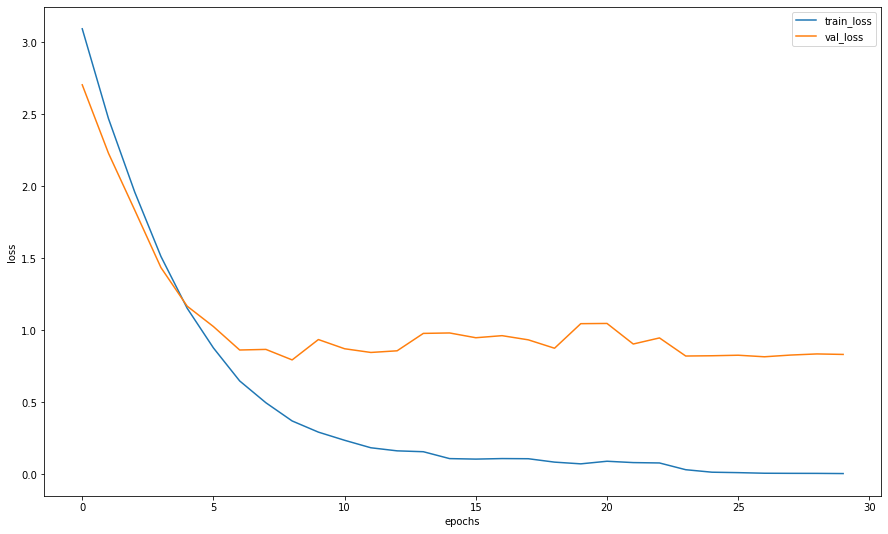

In [12]:
skf = StratifiedKFold(n_splits=N_FOLDS, shuffle=True, random_state=SEED)

for fold, (train_idx, val_idx) in enumerate(skf.split(train_val_files, label_encoder.transform(train_val_labels))):
    print('\nFOLD', fold+1)
    val_dataset = SimpsonsDataset(np.array(train_val_files)[val_idx], mode='val')
    train_dataset = SimpsonsDataset(np.array(train_val_files)[train_idx], mode='train')
    
    clf = SimpsonCNN(n_classes).to(DEVICE)
    history = train(train_dataset, val_dataset, model=clf, epochs=EPOCHS, batch_size=BATCH_SIZE)
    
    loss, acc, val_loss, val_acc = zip(*history)
    plt.figure(figsize=(15, 9))
    plt.plot(loss, label="train_loss")
    plt.plot(val_loss, label="val_loss")
    plt.legend(loc='best')
    plt.xlabel("epochs")
    plt.ylabel("loss")
    plt.show()
    plt.close()
    
    probs = predict(clf, test_loader)
    preds = label_encoder.inverse_transform(np.argmax(probs, axis=1))
    
    submit[f'fold_{fold+1}'] = preds

In [13]:
torch.cuda.empty_cache()

###  Submission

In [14]:
test_filenames = [path.name for path in test_dataset.files]
submit['Id'] = test_filenames
submit['Expected'] = submit.mode(axis=1)[0]
submit[['Id', 'Expected']].to_csv('./out/PROD_custom_adamw_lrp3.csv', index=False)
submit.head()

,Id,fold_1,Expected
0,img0.jpg,nelson_muntz,img0.jpg
1,img1.jpg,bart_simpson,bart_simpson
2,img10.jpg,ned_flanders,img10.jpg
3,img100.jpg,chief_wiggum,chief_wiggum
4,img101.jpg,apu_nahasapeemapetilon,apu_nahasapeemapetilon
